<a href="https://colab.research.google.com/github/DiogoParreira/NLP_Airbnb_Delisting_Prediction/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=e035f183f6598fa34970d7bb305063959380fe7182a01d416a8c8e7a1b8c191c
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [6]:
!pip install deep_translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.1 MB/s eta 0:00:00


In [7]:
!pip install transformers torch langdetect deep_translator tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
import re
from deep_translator import GoogleTranslator
import time
from IPython.display import clear_output
from transformers import AutoTokenizer, AutoModel, DistilBertTokenizer, DistilBertModel, MarianMTModel, MarianTokenizer
import torch
from tqdm.notebook import tqdm

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
!gdown 1Y63uPJCSWvlefU-HYpuVumaiqgjHjpb8

Downloading...
From (original): https://drive.google.com/uc?id=1Y63uPJCSWvlefU-HYpuVumaiqgjHjpb8
From (redirected): https://drive.google.com/uc?id=1Y63uPJCSWvlefU-HYpuVumaiqgjHjpb8&confirm=t&uuid=ba31d9ba-3793-476d-99b3-95a255f9cc4a
To: /content/Project Corpora.zip
100% 55.4M/55.4M [00:00<00:00, 103MB/s]


In [10]:
!unzip '/content/Project Corpora.zip'

Archive:  /content/Project Corpora.zip
  inflating: Project Corpora/test.xlsx  
  inflating: Project Corpora/test_reviews.xlsx  
  inflating: Project Corpora/train.xlsx  
  inflating: Project Corpora/train_reviews.xlsx  


In [11]:
!rm '/content/Project Corpora.zip'

In [12]:
df_train = pd.read_excel('/content/Project Corpora/train.xlsx')
df_train_reviews = pd.read_excel('/content/Project Corpora/train_reviews.xlsx')
df_test = pd.read_excel('/content/Project Corpora/test.xlsx')
df_test_reviews = pd.read_excel('/content/Project Corpora/test_reviews.xlsx')

In [13]:
df_train

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0
...,...,...,...,...
6243,6244,"Studio 15 is a new, very well decorated and co...",I'm a Brand Manager from Lisbon in Portugal bu...,0
6244,6245,Lisbon meets a cosmopolitan industrial one-bed...,Home is where feelings are visitors. How do we...,0
6245,6246,<b>License number</b><br />Exempt,I am a travel agent passionate by cultures. \n...,1
6246,6247,Campo Pequeno Prestige is a classy and top qua...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0


In [14]:
df_train_reviews.head(30)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."
5,1,Our stay in Lisbon Tip Hostel was very good. T...
6,1,Close to shops in town and a comfortable place...
7,1,Young and friendly staff. Great location along...
8,1,The place is just off the Parque metro stop wh...
9,1,Had a nice stay at this hostel. The beds were ...


# Exploration

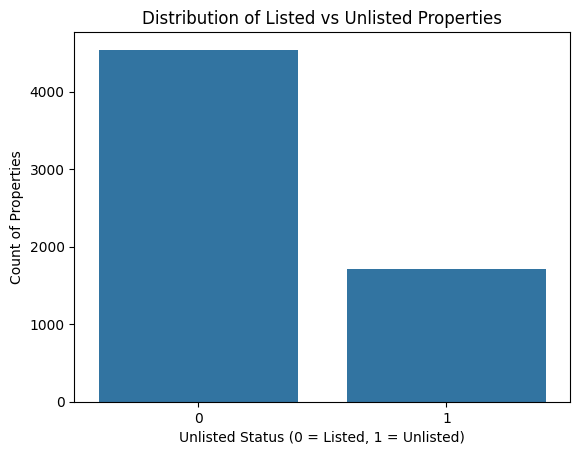

In [15]:
# distribution of classes

sns.countplot(x='unlisted', data=df_train)
plt.title('Distribution of Listed vs Unlisted Properties')
plt.xlabel('Unlisted Status (0 = Listed, 1 = Unlisted)')
plt.ylabel('Count of Properties')
plt.show()

In [16]:
# Let's create a wordcloud

def plot_word_cloud(text_series):
    text = ' '.join(text_series.dropna()).lower()
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Word Cloud for description


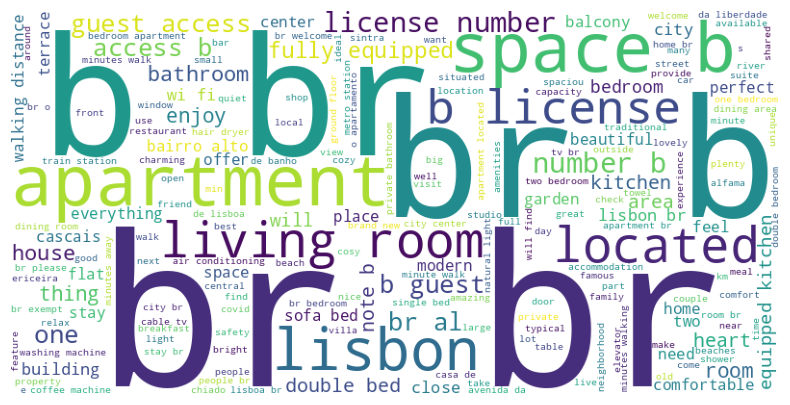

Word Cloud for host_about


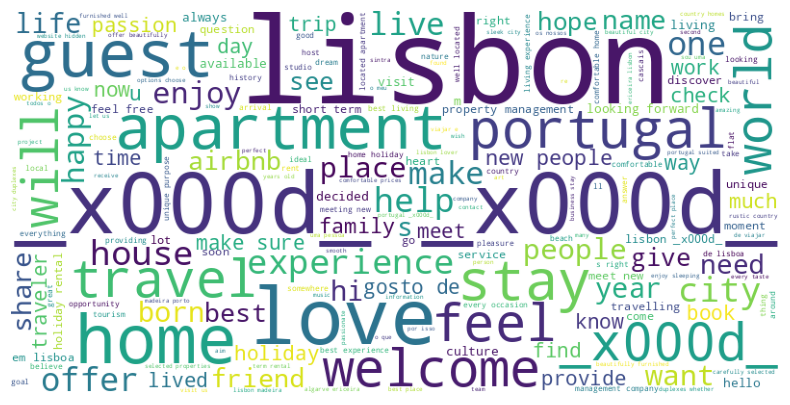

Word Cloud for comments


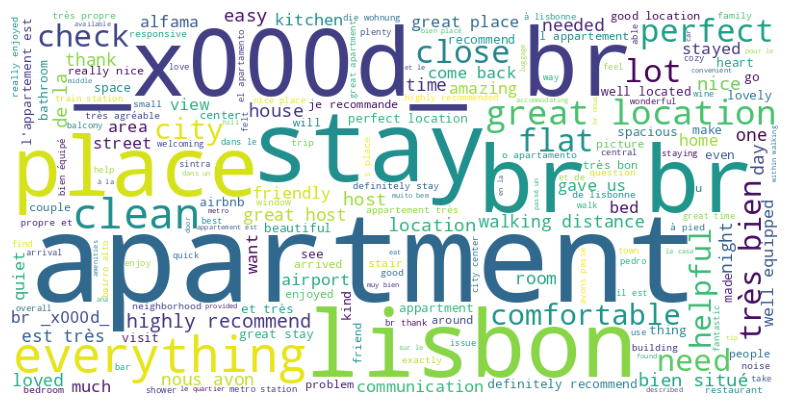

In [17]:
# For df_train
for column in ['description', 'host_about']:
    print(f"Word Cloud for {column}")
    plot_word_cloud(df_train[column])

# For df_train_reviews
print("Word Cloud for comments")
plot_word_cloud(df_train_reviews['comments'])

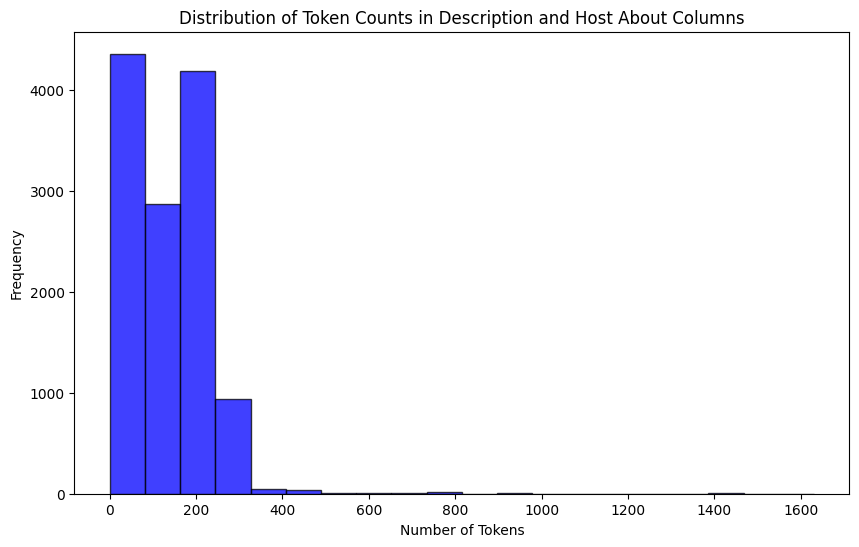

In [18]:
def count_tokens(text):
    return len(word_tokenize(text))

# Get token counts for both columns
description_token_counts = df_train['description'].apply(count_tokens)
host_about_token_counts = df_train['host_about'].apply(count_tokens)

all_token_counts = list(description_token_counts) + list(host_about_token_counts)

# Create a histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(all_token_counts, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.title('Distribution of Token Counts in Description and Host About Columns')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# Data Preprocessing

In [19]:
# Let's check examples where those unwanted words appear

def display_sentences_with_substring(df, column, substring, num_sentences=5):
    contains_substring = df[df[column].str.contains(substring, na=False, regex=False)]

    # Print examples
    print(f"Examples of sentences containing '{substring}' in {column}:")
    for example in contains_substring[column].head(num_sentences):
        print("-" * 80)
        print(example)
    print("-" * 80)

In [20]:
# Display examples from 'description' containing "br"
display_sentences_with_substring(df_train, 'description', 'br')

# Display examples from 'comments' containing "_x000d"
display_sentences_with_substring(df_train_reviews, 'comments', 'x0')

Examples of sentences containing 'br' in description:
--------------------------------------------------------------------------------
This is a shared mixed room in our hostel, with shared bathroom.<br />We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.<br /><br /><b>The space</b><br />We offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and  There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 and we have a late check out at 11:00, so you can sleep until late!<br /><br /><b>Guest access</b><br />All rooms have key-card access.
--------------------------------------------------------------------------------
Trafaria’s House is a cozy and familiar villa where yo

### Check for different languages

In [21]:
# check for languages

DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'error'

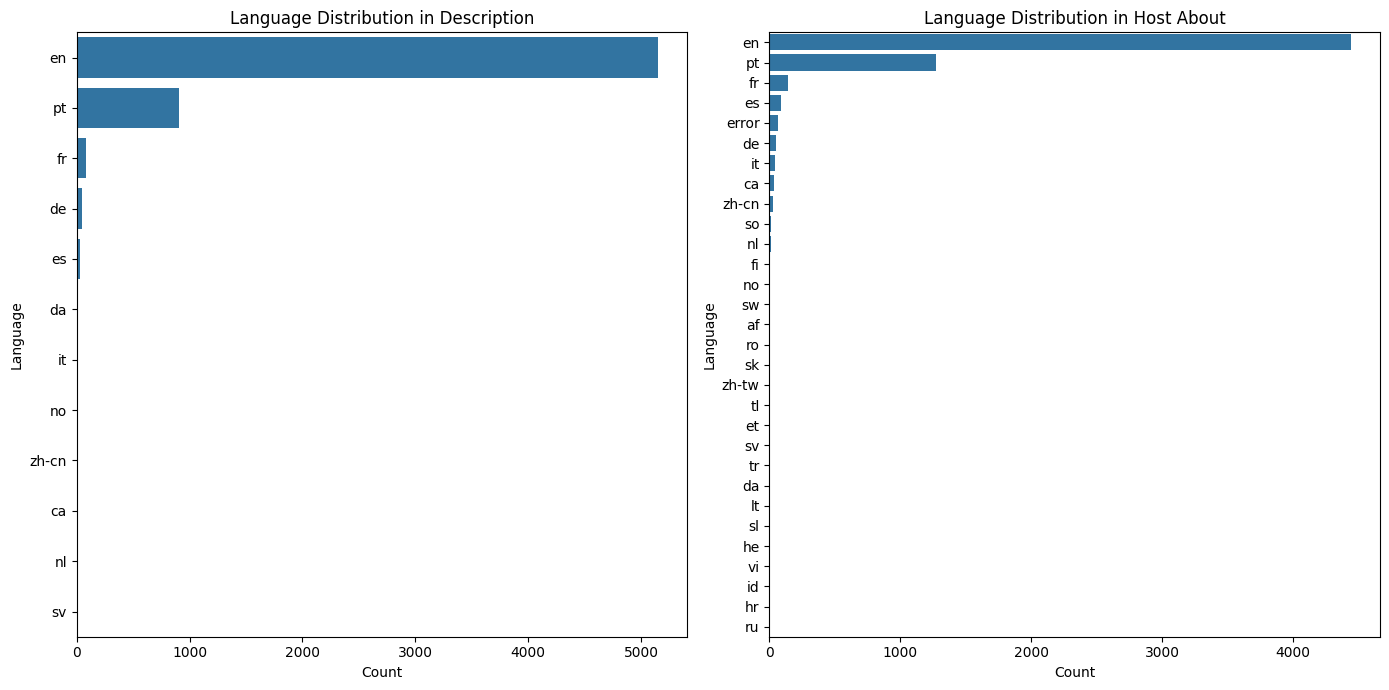

In [22]:
# check language in the two columns of df_train
df_train['lang_description'] = df_train['description'].apply(detect_language)
df_train['lang_host_about'] = df_train['host_about'].apply(detect_language)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(y='lang_description', data=df_train, order = df_train['lang_description'].value_counts().index)
plt.title('Language Distribution in Description')
plt.xlabel('Count')
plt.ylabel('Language')

plt.subplot(1, 2, 2)
sns.countplot(y='lang_host_about', data=df_train, order = df_train['lang_host_about'].value_counts().index)
plt.title('Language Distribution in Host About')
plt.xlabel('Count')
plt.ylabel('Language')

plt.tight_layout()
plt.show()

# checking for rows where language of description and host_about don't match
mismatch_mask = df_train['lang_description'] != df_train['lang_host_about']
percentage_mismatch = (mismatch_mask.sum() / len(df_train)) * 100
percentage_mismatch

In [36]:
df_train.head()

,index,description,host_about,unlisted,lang_description,lang_host_about
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr


In [34]:
import pandas as pd

# Calculate language distribution in description column
lang_description_counts = df_train['lang_description'].value_counts()
lang_description_percentage = (lang_description_counts / lang_description_counts.sum()) * 100

# Calculate language distribution in host_about column
lang_host_about_counts = df_train['lang_host_about'].value_counts()
lang_host_about_percentage = (lang_host_about_counts / lang_host_about_counts.sum()) * 100

# Combine languages from both columns and remove duplicates
all_languages = list(set(lang_description_counts.index) | set(lang_host_about_counts.index))

# Create DataFrame
language_distribution_df = pd.DataFrame(index=all_languages)
language_distribution_df['Desc Count'] = lang_description_counts
language_distribution_df['Desc Percentage'] = lang_description_percentage
language_distribution_df['Host Count'] = lang_host_about_counts
language_distribution_df['Host Percentage'] = lang_host_about_percentage

# Fill missing values with zeros
language_distribution_df.fillna(0, inplace=True)

# Sort by Description Percentage in descending order
language_distribution_df.sort_values(by='Desc Percentage', ascending=False, inplace=True)

# Display the DataFrame
print(language_distribution_df)




       Desc Count  Desc Percentage  Host Count  Host Percentage
en         5152.0        82.458387        4440        71.062740
pt          909.0        14.548656        1272        20.358515
fr           84.0         1.344430         139         2.224712
de           45.0         0.720230          54         0.864277
es           27.0         0.432138          90         1.440461
da           13.0         0.208067           1         0.016005
it            6.0         0.096031          46         0.736236
no            4.0         0.064020           6         0.096031
zh-cn         3.0         0.048015          28         0.448143
nl            2.0         0.032010           9         0.144046
ca            2.0         0.032010          38         0.608195
sv            1.0         0.016005           3         0.048015
ru            0.0         0.000000           1         0.016005
he            0.0         0.000000           1         0.016005
vi            0.0         0.000000      

In [37]:
from transformers import MarianMTModel, MarianTokenizer

# Load pre-trained model and tokenizer
model_name = "Helsinki-NLP/opus-mt-en-ROMANCE"  # English to Romance languages
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

def translate_text(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(**inputs, forced_bos_token_id=model.config.decoder_start_token_id)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Function to translate text if source language is not English
def translate_if_not_english(text, lang_code):
    if lang_code != 'en':
        return translate_text(text, model, tokenizer)
    else:
        return text

# Apply translation function to 'description' column and create a new column
df_train['description_english'] = df_train.apply(lambda row: translate_if_not_english(row['description'], row['lang_description']), axis=1)

# Apply translation function to 'host_about' column and create a new column
df_train['host_about_english'] = df_train.apply(lambda row: translate_if_not_english(row['host_about'], row['lang_host_about']), axis=1)

print(df_train)



/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


KeyboardInterrupt: 